In [2]:
import math
!pip install yfinance
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [3]:
df = yf.download('XLF', start='2018-11-30', end='2022-12-01')
df

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,XLF,XLF,XLF,XLF,XLF
Date,,,,,
2018-11-30,23.719631,23.816375,23.490966,23.526146,45435200
2018-12-03,23.869146,24.159375,23.702046,24.062634,65332700
2018-12-04,22.831350,23.754807,22.717018,23.746012,110918600
2018-12-06,22.514740,22.523535,21.925487,22.321253,134687100
2018-12-07,22.083797,22.778587,21.978259,22.461975,86740000
...,...,...,...,...,...
2022-11-23,34.430843,34.516945,34.229938,34.229938,27916900
2022-11-25,34.545639,34.593472,34.402136,34.469103,11266500


Text(0, 0.5, 'Close Prices ($)')

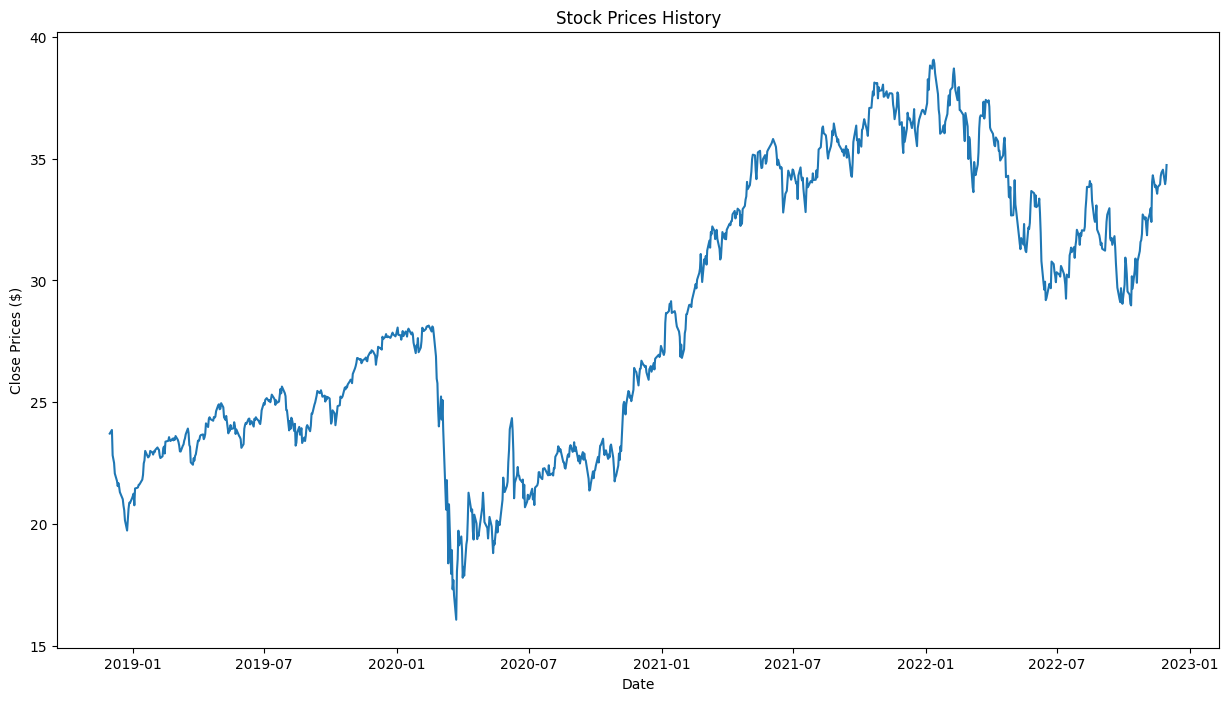

In [4]:
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(df['Close'])
plt.xlabel('Date')

# Plotting the Y Label
plt.ylabel('Close Prices ($)')

In [5]:
window_size = 252

close_prices = df['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(window_size, len(train_data)):
    x_train.append(train_data[i-window_size:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [6]:
test_data = scaled_data[training_data_len- window_size: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(window_size, len(test_data)):
  x_test.append(test_data[i-window_size:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [7]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 252, 100)       │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,751 (483.40 KB)

 Trainable params: 123,751 (483.40 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
554/554 ━━━━━━━━━━━━━━━━━━━━ 160s 270ms/step - loss: 0.0080
Epoch 2/3
554/554 ━━━━━━━━━━━━━━━━━━━━ 201s 269ms/step - loss: 0.0019
Epoch 3/3
554/554 ━━━━━━━━━━━━━━━━━━━━ 204s 272ms/step - loss: 0.0018


In [9]:
x_train.shape

(554, 252, 1)

In [10]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step


np.float64(0.48148498724942185)

<ipython-input-11-845d5aef46a5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


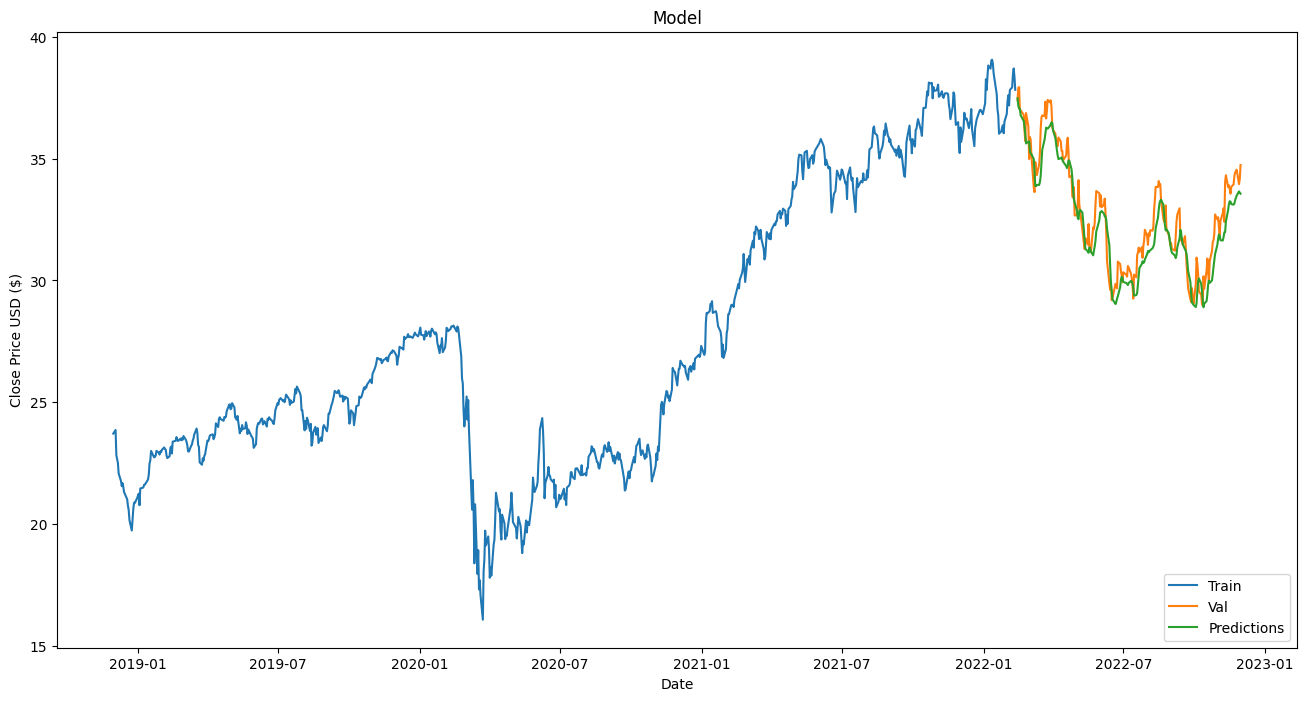

In [11]:
data = df[['Close']]

train = data[:training_data_len]
validation = data[training_data_len:]

validation['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train['Close'])
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [12]:
validation.columns

MultiIndex([(      'Close', 'XLF'),
            ('Predictions',    '')],
           names=['Price', 'Ticker'])

In [13]:
days = [1, 4, 21, 61, 124]
time = ['1 day', '1 week', '1 month', '3 months', '6 months', '1 year']


def percent_error(actual_price, predicted_price):
  return round((abs(actual_price - predicted_price) / predicted_price * 100), 2)


for i in range(5):

  predicted_price = predictions[days[i]][0]
  actual_price = y_test[days[i]]

  print(f'After {time[i]}')
  predicted_price = round(float(predicted_price), 2)
  actual_price = round(float(actual_price), 2)


  print(f'The Actual Price: {actual_price}')
  print(f'The Predicted Price: {predicted_price}')


  print(f'Percent Error: {percent_error(actual_price, predicted_price)}\n')

  percent_errors = 0

for i in range(len(predictions)):
  predicted_price = predictions[i][0]
  actual_price = y_test[i]

  predicted_price = float(predicted_price)
  actual_price = float(actual_price)

  percent_errors += percent_error(actual_price, predicted_price)

print(f"Average Percent Errors = {round (percent_errors / len(predictions),2)}")

print(f'RMSE = {round(float(rmse),2)}')

After 1 day
The Actual Price: 37.91
The Predicted Price: 37.16
Percent Error: 2.02

After 1 week
The Actual Price: 36.98
The Predicted Price: 36.78
Percent Error: 0.54

After 1 month
The Actual Price: 36.24
The Predicted Price: 34.3
Percent Error: 5.66

After 3 months
The Actual Price: 31.29
The Predicted Price: 31.64
Percent Error: 1.11

After 6 months
The Actual Price: 33.84
The Predicted Price: 32.14
Percent Error: 5.29

Average Percent Errors = 2.13
RMSE = 0.48


<ipython-input-13-dc1795bd5c53>:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_price = round(float(actual_price), 2)
<ipython-input-13-dc1795bd5c53>:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_price = float(actual_price)


In [14]:
predictions

array([[37.47032 ],
       [37.16128 ],
       [37.052757],
       [37.037567],
       [36.779186],
       [36.54004 ],
       [36.32469 ],
       [35.998405],
       [35.62135 ],
       [35.692303],
       [35.70811 ],
       [35.32215 ],
       [35.21571 ],
       [35.18061 ],
       [34.985287],
       [34.430634],
       [33.885117],
       [33.86685 ],
       [33.921158],
       [33.921143],
       [34.037903],
       [34.295387],
       [34.805588],
       [35.36046 ],
       [35.777046],
       [36.00518 ],
       [36.27226 ],
       [36.24551 ],
       [36.224663],
       [36.338867],
       [36.418606],
       [36.490364],
       [36.458122],
       [36.155876],
       [35.84613 ],
       [35.580624],
       [35.347393],
       [35.13058 ],
       [34.98276 ],
       [35.014355],
       [35.04685 ],
       [34.963596],
       [34.877213],
       [34.69833 ],
       [34.610626],
       [34.7168  ],
       [34.919453],
       [34.92197 ],
       [34.55835 ],
       [34.21456 ],
